---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
train_df=pd.read_csv('train.csv',encoding = "ISO-8859-1")
test_df=pd.read_csv('test.csv',encoding='ISO-8859-1')
latlon_df=pd.read_csv('latlons.csv',encoding='ISO-8859-1')
address_df=pd.read_csv('addresses.csv',encoding='ISO-8859-1')
train_df.head()


/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [2]:
train_df.isna().any()

ticket_id                     False
agency_name                   False
inspector_name                False
violator_name                  True
violation_street_number       False
violation_street_name         False
violation_zip_code             True
mailing_address_str_number     True
mailing_address_str_name       True
city                          False
state                          True
zip_code                       True
non_us_str_code                True
country                       False
ticket_issued_date            False
hearing_date                   True
violation_code                False
violation_description         False
disposition                   False
fine_amount                    True
admin_fee                     False
state_fee                     False
late_fee                      False
discount_amount               False
clean_up_cost                 False
judgment_amount               False
payment_amount                False
balance_due                 

In [3]:
train_df['state'].isna().value_counts()

False    250213
True         93
Name: state, dtype: int64

In [4]:
test_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [5]:
test_df.columns.shape

(27,)

In [6]:
train_df.columns.shape

(34,)

In [7]:
train_df['compliance'].isna().value_counts()

False    159880
True      90426
Name: compliance, dtype: int64

In [8]:
train_df['compliance'].dropna(axis=0,inplace=True)

In [9]:
train_df['compliance'].unique()

array([0., 1.])

In [10]:
latlon_df.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [11]:
address_df.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [12]:
train_df=train_df[train_df['country']=='USA']

In [13]:
train_df['country'].unique()

array(['USA'], dtype=object)

In [14]:
test_df['country'].isna().any()

False

In [15]:
address_df=pd.merge(address_df,latlon_df,on='address')

In [16]:
train_df=pd.merge(train_df,address_df,on='ticket_id')

In [17]:
train_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [18]:
test_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [19]:
test_df=pd.merge(test_df,address_df,on='ticket_id')
test_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,address,lat,lon
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"10041 roseberry, Detroit MI",42.407581,-82.986642
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"1835 central, Detroit MI",42.309661,-83.122426
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"1700 central, Detroit MI",42.308830,-83.121116


In [20]:
train_df.drop(['agency_name', 'inspector_name', 'violator_name', 'non_us_str_code', 'violation_description', 
                'grafitti_status', 'state_fee', 'admin_fee', 'ticket_issued_date', 'hearing_date',

                'payment_amount', 'balance_due', 'payment_date', 'payment_status', 
                'collection_status', 'compliance_detail', 
                
                'violation_zip_code', 'country', 'address', 'violation_street_number',
                'violation_street_name', 'mailing_address_str_number', 'mailing_address_str_name', 
                'city', 'state', 'zip_code', 'address'], axis=1, inplace=True)

In [21]:
train_df.columns

Index(['ticket_id', 'violation_code', 'disposition', 'fine_amount', 'late_fee',
       'discount_amount', 'clean_up_cost', 'judgment_amount', 'compliance',
       'lat', 'lon'],
      dtype='object')

In [22]:
test_df.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status', 'address', 'lat',
       'lon'],
      dtype='object')

In [23]:
train_df['compliance'].isna().value_counts()

False    159869
True      90424
Name: compliance, dtype: int64

In [24]:
train_df['compliance'].dropna(axis=0,inplace=True)

In [25]:
train_df.shape

(250293, 11)

In [26]:
train_df.isna().any()

ticket_id          False
violation_code     False
disposition        False
fine_amount         True
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
compliance          True
lat                 True
lon                 True
dtype: bool

In [27]:
train_df['fine_amount'].fillna(train_df['fine_amount'].median,inplace=True)

In [28]:
train_df['fine_amount'].isna().any()

False

In [29]:
train_df.isna().any()

ticket_id          False
violation_code     False
disposition        False
fine_amount        False
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
compliance          True
lat                 True
lon                 True
dtype: bool

In [30]:
train_df['compliance']=train_df['compliance'].dropna(axis=0)

In [31]:
train_df1 = train_df[(train_df['compliance'] == 0) | (train_df['compliance'] == 1)]

In [32]:
train_df1.head()

,ticket_id,violation_code,disposition,fine_amount,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon
0,22056,9-1-36(a),Responsible by Default,250,25.0,0.0,0.0,305.0,0.0,42.390729,-83.124268
1,27586,61-63.0600,Responsible by Determination,750,75.0,0.0,0.0,855.0,1.0,42.326937,-83.135118
5,22046,9-1-36(a),Responsible by Default,250,25.0,0.0,0.0,305.0,0.0,42.145257,-83.208233
6,18738,61-63.0500,Responsible by Default,750,75.0,0.0,0.0,855.0,0.0,42.433466,-83.023493
7,18735,61-63.0100,Responsible by Default,100,10.0,0.0,0.0,140.0,0.0,42.388641,-83.037858


In [33]:
train_df1['lat'].fillna(train_df1['lat'].mean(),inplace=True)

train_df1.isna().any()

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ticket_id          False
violation_code     False
disposition        False
fine_amount        False
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
compliance         False
lat                False
lon                 True
dtype: bool

In [34]:
train_df1['lon'].fillna(train_df1['lon'].mean(),inplace=True)
train_df1.isna().any()

ticket_id          False
violation_code     False
disposition        False
fine_amount        False
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
compliance         False
lat                False
lon                False
dtype: bool

In [35]:
train_df1['violation_code']

0          9-1-36(a)
1         61-63.0600
5          9-1-36(a)
6         61-63.0500
7         61-63.0100
             ...    
250265    22-2-88(b)
250274    22-2-88(b)
250275    22-2-88(b)
250277       22-2-61
250280    22-2-88(b)
Name: violation_code, Length: 159869, dtype: object

In [36]:
targets=train_df1['compliance']
train_df1.drop('compliance',axis=1,inplace=True)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
train_columns=train_df1.columns.values
train_columns

array(['ticket_id', 'violation_code', 'disposition', 'fine_amount',
       'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount',
       'lat', 'lon'], dtype=object)

In [38]:
test_df['lat'].fillna(test_df['lat'].mean(),inplace=True)
test_df['lon'].fillna(test_df['lon'].mean(),inplace=True)
test_df[train_columns].isna().any()

ticket_id          False
violation_code     False
disposition        False
fine_amount        False
late_fee           False
discount_amount    False
clean_up_cost      False
judgment_amount    False
lat                False
lon                False
dtype: bool

In [39]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df1['disposition'].append(test_df['disposition'], ignore_index=True))
train_df1['disposition'] = label_encoder.transform(train_df1['disposition'])
test_df['disposition'] = label_encoder.transform(test_df['disposition'])

label_encoder.fit(train_df1['violation_code'].append(test_df['violation_code'], ignore_index=True))
train_df1['violation_code'] = label_encoder.transform(train_df1['violation_code'])
test_df['violation_code'] = label_encoder.transform(test_df['violation_code'])

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Label Encoder function
Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

In [40]:
X=train_df1
y=targets
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)

In [41]:
test_df1=test_df[train_columns]

## Random Forest Regressor

In [42]:
reg_rf=RandomForestRegressor()
param_grid={'n_estimators':[5,7,9,10], 'max_depth':[5,7,9,10]}
grid_search=GridSearchCV(reg_rf,param_grid,scoring='roc_auc')
grid_result=grid_search.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [43]:
print('Score:',grid_result.best_score_.round(2))

Score: 0.82


In [44]:
print('Best parameters:',grid_result.best_params_)

Best parameters: {'max_depth': 10, 'n_estimators': 9}


In [45]:
results_df=pd.DataFrame(grid_search.predict(test_df1),columns=['Compliance'])

In [46]:
ticket_id=test_df1.loc[:,'ticket_id']
ticket_id.head()

0    284932
1    285362
2    285361
3    285338
4    285346
Name: ticket_id, dtype: int64

In [47]:
results_df['ticket_id']=ticket_id

In [49]:
results_df=results_df.rename(columns={'Compliance':'Compliance predicted'})
results_df.head()

,ticket_id,Compliance predicted
0,284932,0.085757
1,285362,0.050473
2,285361,0.222529
3,285338,0.077627
4,285346,0.242552


In [122]:
results_df.index=results_df.ticket_id


In [124]:
results_df.drop('ticket_id',axis=1,inplace=True)
results_df.head()

,Compliance predicted
ticket_id,
284932,0.085757
285362,0.050473
285361,0.222529
285338,0.077627
285346,0.242552


In [118]:
results_df.sort_values(by='Compliance predicted',ascending=False)

,ticket_id,Compliance predicted
11476,304537,1.000000
32441,334671,1.000000
32544,334578,1.000000
54846,366899,1.000000
54860,366241,1.000000
32543,334571,1.000000
32488,335072,1.000000
32486,334598,1.000000
54880,366893,1.000000
32459,334484,1.000000


## Using Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=365)
reg_log=LogisticRegression()
reg_log.fit(X_train,y_train)


/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
reg_log.predict(X_test)


array([0., 0., 0., ..., 0., 0., 0.])

In [64]:
results_log_df1=pd.DataFrame(y_test)

In [67]:
results_log_df1['compliance'].value_counts()

0.0    29650
1.0     2324
Name: compliance, dtype: int64

In [72]:
results_log_df1.reset_index(drop=True,inplace=True)

In [74]:
results_log_df1['Predicted compliance']=y_test

In [77]:
results_log_df1.drop('Predicted compliance',axis=1,inplace=True)

In [79]:
y_pred=reg_log.predict(X_test)

In [80]:
results_log_df1['Predicted compliance']=y_pred

In [82]:
results_log_df1.head()

,compliance,Predicted compliance
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [84]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,roc_curve,auc
confusion_matrix(y_test,y_pred)

array([[29603,    47],
       [ 2267,    57]])

In [95]:
y_scores_lr = reg_log.fit(X_train, y_train).decision_function(X_test)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Recall')

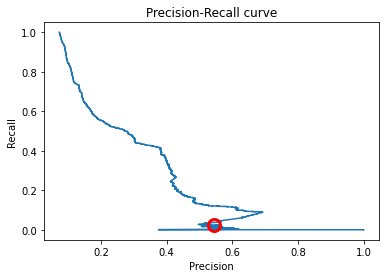

In [98]:
precision,recall,threshold=precision_recall_curve(y_test,y_scores_lr)
closest_zero=np.argmin(np.abs(threshold))
closest_zero_p=precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.plot(precision,recall)
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.title('Precision-Recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')

Text(0, 0.5, 'True positive rate')

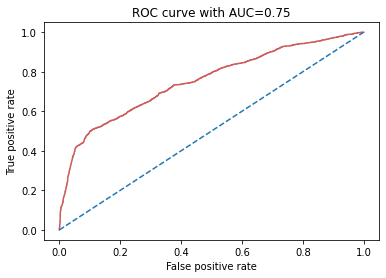

In [103]:
fpr,tpr,_=roc_curve(y_test,y_scores_lr)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],linestyle='--')
auc_reg=auc(fpr,tpr).round(2)
plt.title('ROC curve with AUC={}'.format(auc_reg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# Area Under Curve

AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test. AUC can be computed using the trapezoidal rule. In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

In [109]:
y_act_pred=reg_log.predict(test_df1)

In [111]:
results_df1=pd.DataFrame(test_df1['ticket_id'])

In [113]:
results_df1['Predicted compliance']=y_act_pred

In [117]:
results_df1.sort_values(by='Predicted compliance',ascending=False).head()

,ticket_id,Predicted compliance
9573,301665,1.0
3461,292486,1.0
23429,321376,1.0
1546,288118,1.0
3405,291734,1.0
